# 移动机器人路径规划与跟踪控制系统成果展示

这个notebook展示了完整的移动机器人路径规划与跟踪控制仿真系统的成果，包括：

## 🎯 主要功能
- **4种路径规划算法**: A*, RRT, Dijkstra, 人工势场法
- **3种路径跟踪控制器**: Pure Pursuit, Stanley, PID
- **多场景支持**: 简单、复杂、迷宫等不同难度场景
- **完整性能分析**: 时间、精度、平滑度等多维度评估

## 📊 展示内容
1. 各种路径规划算法的可视化结果
2. 不同控制器的路径跟踪效果
3. 详细的性能指标对比
4. 最优算法组合推荐

让我们开始详细展示各个算法的性能表现！

In [1]:
# 导入必要的库和依赖
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# 设置matplotlib中文字体和图形参数
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# 添加项目根目录到路径
project_root = os.path.dirname(os.path.abspath('.'))
if project_root not in sys.path:
    sys.path.append(project_root)

print("📚 库导入完成")
print(f"🔧 工作目录: {os.getcwd()}")
print(f"📁 项目根目录: {project_root}")

📚 库导入完成
🔧 工作目录: /Users/kk/Desktop/robot
📁 项目根目录: /Users/kk/Desktop


In [2]:
# 导入项目相关模块
try:
    from src.environment.scenario import get_scenario, SCENARIOS
    from src.planning.a_star import AStarPlanner
    from src.planning.rrt import RRTPlanner, RRTStarPlanner
    from src.planning.dijkstra import DijkstraPlanner
    from src.planning.potential_field import PotentialFieldPlanner
    from src.control.pure_pursuit import PurePursuitController
    from src.control.simple_stanley import SimpleStanleyController
    from src.control.simple_pid import SimplePIDController
    from src.robot.kinematic_model import DifferentialDriveRobot
    from src.visualization.plotter import Visualizer, AnimationVisualizer
    
    print("✅ 项目模块导入成功")
    
except ImportError as e:
    print(f"❌ 导入错误: {e}")
    print("请确保在项目根目录运行，并安装所有依赖: pip install -r requirements.txt")
    
# 创建结果目录
os.makedirs('results/images', exist_ok=True)
os.makedirs('results/data', exist_ok=True)
print("📂 结果目录创建完成")

✅ 项目模块导入成功
📂 结果目录创建完成


## 1. 场景初始化与系统准备

在这个部分，我们将：
- 创建测试场景环境
- 初始化所有算法对象
- 设置机器人模型参数

In [3]:
# 创建场景和初始化算法
print("🌍 创建测试场景...")
simple_env = get_scenario('simple')
complex_env = get_scenario('complex')
maze_env = get_scenario('maze')

# 选择场景进行演示
# env = simple_env  # 使用简单场景进行演示
env = complex_env  # 使用复杂场景进行演示
# env = maze_env  # 使用MuZe场景进行演示
print(f"📍 场景信息:")
print(f"   地图尺寸: {env.width} x {env.height}")
print(f"   起点: {env.start}")
print(f"   终点: {env.goal}")
print(f"   障碍物数量: {len(env.obstacles)}")

# 初始化路径规划算法
planners = {
    'A*': AStarPlanner(resolution=0.3, heuristic_weight=1.0),
    'RRT': RRTPlanner(step_size=0.5),
    'Dijkstra': DijkstraPlanner(resolution=0.4),
    'Potential_Field': PotentialFieldPlanner(attractive_gain=1.0, repulsive_gain=3.0, influence_distance=1.5)
}

# 初始化路径跟踪控制器
controllers = {
    'Pure_Pursuit': PurePursuitController(lookahead_distance=1.5),
    'Stanley': SimpleStanleyController(k_crosstrack=0.8, max_angular_velocity=0.6),
    'PID': SimplePIDController(kp=1.2, max_angular_velocity=0.6)
}

# 初始化机器人模型
robot = DifferentialDriveRobot(wheelbase=0.5, max_speed=2.0)

# 初始化可视化工具
visualizer = Visualizer()

print(f"🤖 算法初始化完成:")
print(f"   路径规划算法: {len(planners)} 种")
print(f"   控制算法: {len(controllers)} 种")
print("✅ 系统准备就绪!")

🌍 创建测试场景...
📍 场景信息:
   地图尺寸: 15 x 12
   起点: (1, 1)
   终点: (14, 11)
   障碍物数量: 6
🤖 算法初始化完成:
   路径规划算法: 4 种
   控制算法: 3 种
✅ 系统准备就绪!


## 2. 路径规划算法演示

接下来我们将逐一展示四种路径规划算法的效果：

### 算法简介
- **A*** : 基于启发式搜索的最优路径规划算法
- **RRT** : 快速随机树算法，适用于复杂环境
- **Dijkstra** : 经典最短路径算法，保证最优解
- **人工势场法** : 基于势函数的实时路径规划方法

🎯 A* 算法路径规划演示
✅ A* 规划成功!
   规划时间: 0.787s
   路径长度: 18.53m
   探索节点: 543
   路径点数: 52
✅ A* 规划成功!
   规划时间: 0.787s
   路径长度: 18.53m
   探索节点: 543
   路径点数: 52


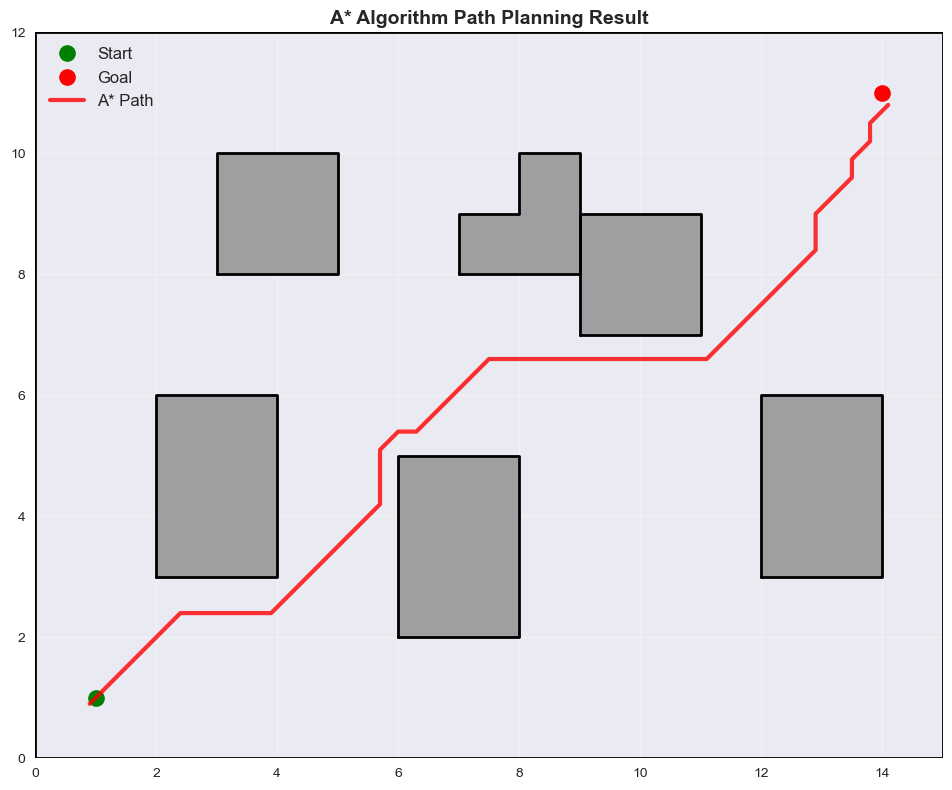

In [4]:
# A* 算法演示
print("🎯 A* 算法路径规划演示")
print("=" * 40)

# 执行A*规划
start_time = time.time()
a_star_path, a_star_metrics = planners['A*'].plan_with_metrics(env.start, env.goal, env)
a_star_time = time.time() - start_time

# 显示结果
if a_star_metrics.success and a_star_path is not None:
    print(f"✅ A* 规划成功!")
    print(f"   规划时间: {a_star_metrics.planning_time:.3f}s")
    print(f"   路径长度: {a_star_metrics.path_length:.2f}m")
    print(f"   探索节点: {a_star_metrics.num_nodes_explored}")
    print(f"   路径点数: {len(a_star_path)}")
else:
    print("❌ A* 规划失败")

# 绘制A*结果
fig, ax = plt.subplots(figsize=(10, 8))
env.visualize(ax=ax)

if a_star_path is not None:
    path_array = np.array(a_star_path)
    ax.plot(path_array[:, 0], path_array[:, 1], 'r-', linewidth=3, label='A* Path', alpha=0.8)
    # ax.plot(a_star_path[0][0], a_star_path[0][1], 'go', markersize=12, label='Start')
    # ax.plot(a_star_path[-1][0], a_star_path[-1][1], 'ro', markersize=12, label='Goal')

ax.set_title('A* Algorithm Path Planning Result', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

🌳 RRT 算法路径规划演示
✅ RRT 规划成功!
   规划时间: 0.556s
   路径长度: 18.68m
   探索节点: 180
   路径点数: 6
✅ RRT 规划成功!
   规划时间: 0.556s
   路径长度: 18.68m
   探索节点: 180
   路径点数: 6


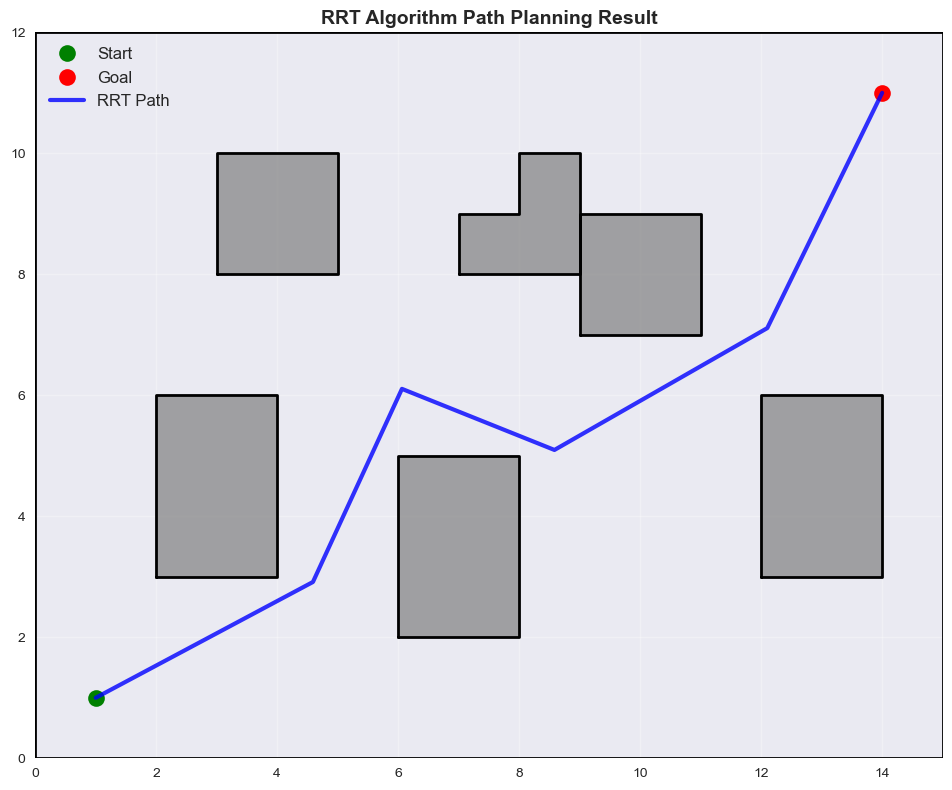

In [5]:
# RRT 算法演示
print("🌳 RRT 算法路径规划演示")
print("=" * 40)

# 执行RRT规划
start_time = time.time()
rrt_path, rrt_metrics = planners['RRT'].plan_with_metrics(env.start, env.goal, env)
rrt_time = time.time() - start_time

# 显示结果
if rrt_metrics.success and rrt_path is not None:
    print(f"✅ RRT 规划成功!")
    print(f"   规划时间: {rrt_metrics.planning_time:.3f}s")
    print(f"   路径长度: {rrt_metrics.path_length:.2f}m")
    print(f"   探索节点: {rrt_metrics.num_nodes_explored}")
    print(f"   路径点数: {len(rrt_path)}")
else:
    print("❌ RRT 规划失败")

# 绘制RRT结果
fig, ax = plt.subplots(figsize=(10, 8))
env.visualize(ax=ax)

if rrt_path is not None:
    path_array = np.array(rrt_path)
    ax.plot(path_array[:, 0], path_array[:, 1], 'b-', linewidth=3, label='RRT Path', alpha=0.8)
    # ax.plot(rrt_path[0][0], rrt_path[0][1], 'go', markersize=12, label='Start')
    # ax.plot(rrt_path[-1][0], rrt_path[-1][1], 'ro', markersize=12, label='Goal')

ax.set_title('RRT Algorithm Path Planning Result', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

📐 Dijkstra 算法路径规划演示
❌ Dijkstra 规划失败
❌ Dijkstra 规划失败


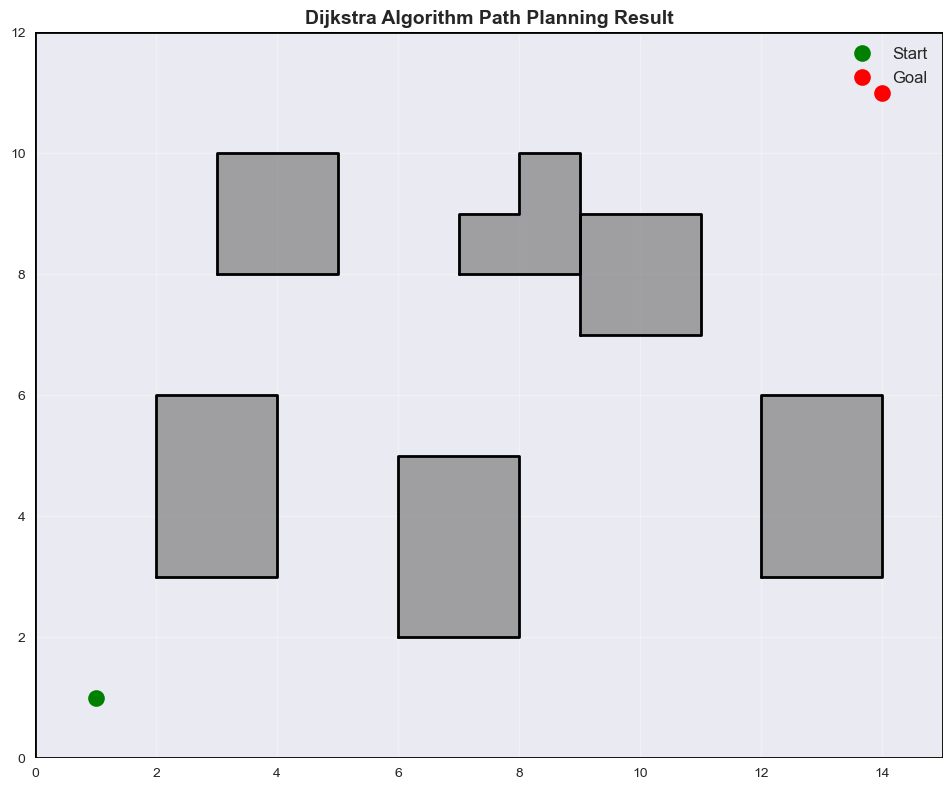

In [6]:
# Dijkstra 算法演示
print("📐 Dijkstra 算法路径规划演示")
print("=" * 40)

# 执行Dijkstra规划
start_time = time.time()
dijkstra_path, dijkstra_metrics = planners['Dijkstra'].plan_with_metrics(env.start, env.goal, env)
dijkstra_time = time.time() - start_time

# 显示结果
if dijkstra_metrics.success and dijkstra_path is not None:
    print(f"✅ Dijkstra 规划成功!")
    print(f"   规划时间: {dijkstra_metrics.planning_time:.3f}s")
    print(f"   路径长度: {dijkstra_metrics.path_length:.2f}m")
    print(f"   探索节点: {dijkstra_metrics.num_nodes_explored}")
    print(f"   路径点数: {len(dijkstra_path)}")
else:
    print("❌ Dijkstra 规划失败")

# 绘制Dijkstra结果
fig, ax = plt.subplots(figsize=(10, 8))
env.visualize(ax=ax)

if dijkstra_path is not None:
    path_array = np.array(dijkstra_path)
    ax.plot(path_array[:, 0], path_array[:, 1], 'g-', linewidth=3, label='Dijkstra Path', alpha=0.8)
    # ax.plot(dijkstra_path[0][0], dijkstra_path[0][1], 'go', markersize=12, label='Start')
    # ax.plot(dijkstra_path[-1][0], dijkstra_path[-1][1], 'ro', markersize=12, label='Goal')

ax.set_title('Dijkstra Algorithm Path Planning Result', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

⚡ 人工势场法路径规划演示
Potential field planning did not reach goal. Final distance: 6.846
❌ 势场法规划失败
Potential field planning did not reach goal. Final distance: 6.846
❌ 势场法规划失败


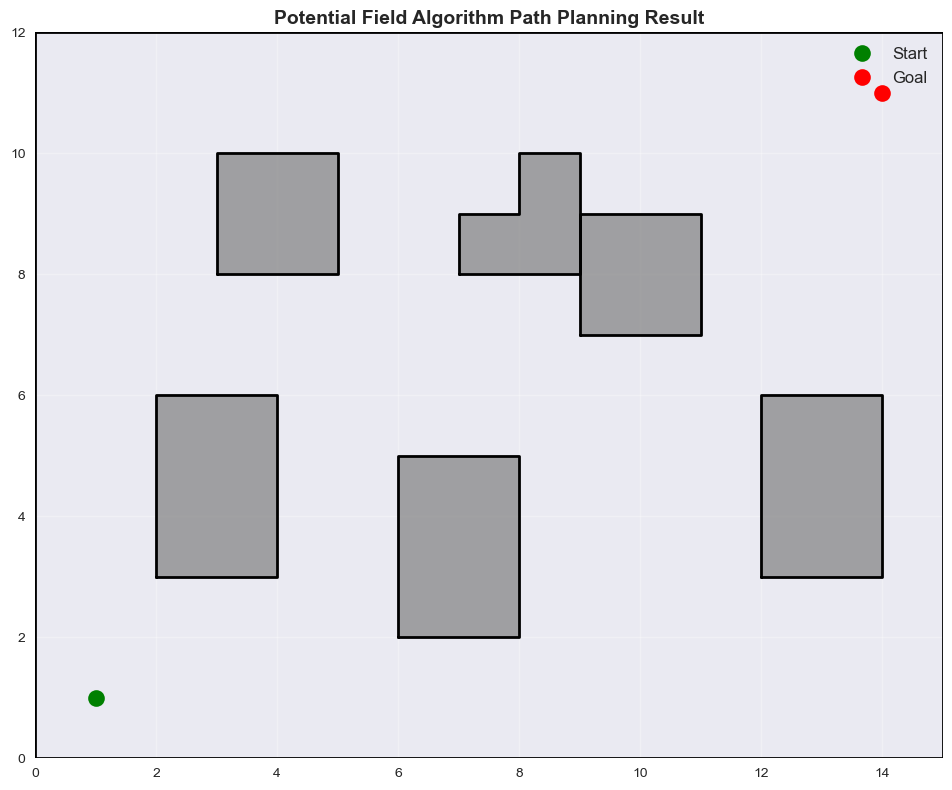

In [7]:
# 人工势场法演示
print("⚡ 人工势场法路径规划演示")
print("=" * 40)

# 执行势场法规划
start_time = time.time()
pf_path, pf_metrics = planners['Potential_Field'].plan_with_metrics(env.start, env.goal, env)
pf_time = time.time() - start_time

# 显示结果
if pf_metrics.success and pf_path is not None:
    print(f"✅ 势场法规划成功!")
    print(f"   规划时间: {pf_metrics.planning_time:.3f}s")
    print(f"   路径长度: {pf_metrics.path_length:.2f}m")
    print(f"   探索节点: {pf_metrics.num_nodes_explored}")
    print(f"   路径点数: {len(pf_path)}")
else:
    print("❌ 势场法规划失败")

# 绘制势场法结果
fig, ax = plt.subplots(figsize=(10, 8))
env.visualize(ax=ax)

if pf_path is not None:
    path_array = np.array(pf_path)
    ax.plot(path_array[:, 0], path_array[:, 1], 'm-', linewidth=3, label='Potential Field Path', alpha=0.8)
    # ax.plot(pf_path[0][0], pf_path[0][1], 'go', markersize=12, label='Start')
    # ax.plot(pf_path[-1][0], pf_path[-1][1], 'ro', markersize=12, label='Goal')

ax.set_title('Potential Field Algorithm Path Planning Result', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. 路径跟踪控制算法演示

现在我们使用A*算法规划的路径作为参考，演示三种不同的路径跟踪控制器：

### 控制器简介
- **Pure Pursuit** : 纯跟踪控制器，简单有效的几何跟踪方法
- **Stanley** : 基于前轮位置的横向控制器，精度较高
- **PID** : 经典比例积分微分控制器，鲁棒性好

In [8]:
# 选择参考路径进行跟踪演示
# 使用A*算法的路径作为参考路径（如果成功的话）
reference_path = None
if a_star_metrics.success and a_star_path is not None:
    reference_path = a_star_path
    print(f"✅ 使用A*路径作为参考路径 (长度: {len(reference_path)} 点)")
elif dijkstra_metrics.success and dijkstra_path is not None:
    reference_path = dijkstra_path
    print(f"✅ 使用Dijkstra路径作为参考路径 (长度: {len(reference_path)} 点)")
else:
    print("❌ 没有可用的参考路径")
    
if reference_path:
    print(f"📍 参考路径信息:")
    print(f"   起点: {reference_path[0]}")
    print(f"   终点: {reference_path[-1]}")
    path_length = sum(np.linalg.norm(np.array(reference_path[i+1]) - np.array(reference_path[i])) 
                      for i in range(len(reference_path)-1))
    print(f"   总长度: {path_length:.2f}m")

✅ 使用A*路径作为参考路径 (长度: 52 点)
📍 参考路径信息:
   起点: (0.8999999999999999, 0.8999999999999999)
   终点: (14.100000000000012, 10.800000000000004)
   总长度: 18.53m


🎯 Pure Pursuit 控制器演示
✅ Pure Pursuit 跟踪成功!
   跟踪时间: 0.013s
   最大横向误差: 0.531m
   RMS横向误差: 0.233m
   控制平滑度: 0.044
   轨迹点数: 109


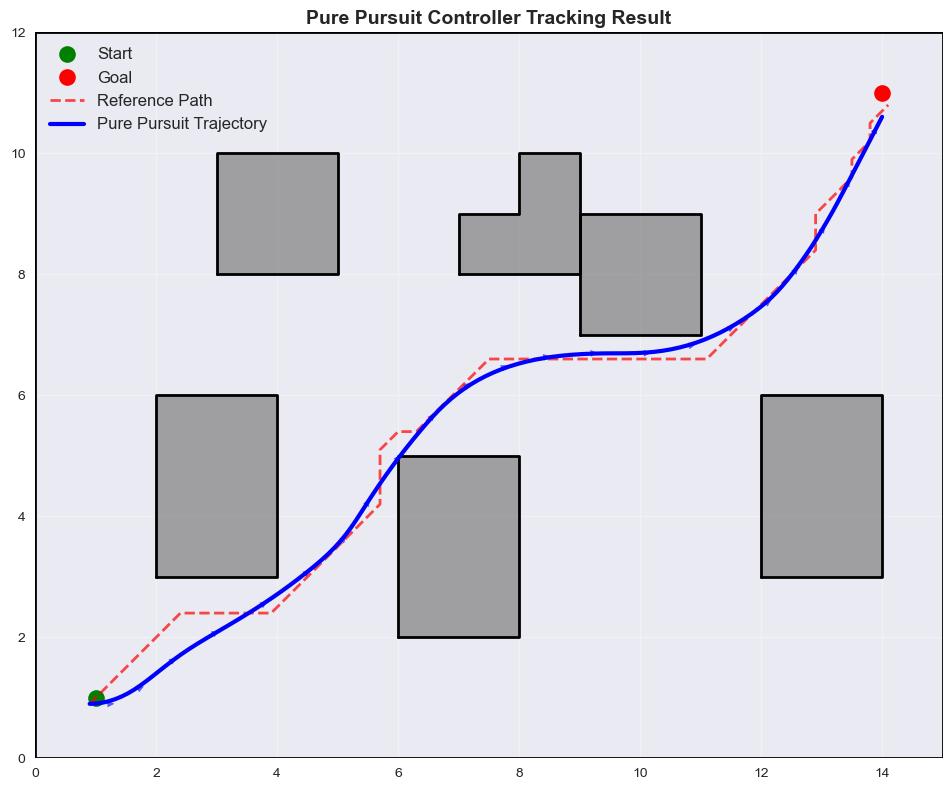

In [9]:
# Pure Pursuit 控制器演示
if reference_path:
    print("🎯 Pure Pursuit 控制器演示")
    print("=" * 40)
    
    # 重置机器人到起点
    robot.set_state(reference_path[0][0], reference_path[0][1], 0)
    
    # 执行Pure Pursuit跟踪
    start_time = time.time()
    pp_trajectory, pp_metrics = controllers['Pure_Pursuit'].track_path(
        robot, reference_path, dt=0.1, max_time=30.0, goal_tolerance=0.3
    )
    pp_time = time.time() - start_time
    
    # 显示结果
    if pp_metrics.success:
        print(f"✅ Pure Pursuit 跟踪成功!")
        print(f"   跟踪时间: {pp_metrics.tracking_time:.3f}s")
        print(f"   最大横向误差: {pp_metrics.max_lateral_error:.3f}m")
        print(f"   RMS横向误差: {pp_metrics.rms_lateral_error:.3f}m")
        print(f"   控制平滑度: {pp_metrics.control_smoothness:.3f}")
        print(f"   轨迹点数: {len(pp_trajectory)}")
    else:
        print("❌ Pure Pursuit 跟踪失败")
    
    # 绘制Pure Pursuit结果
    fig, ax = plt.subplots(figsize=(10, 8))
    env.visualize(ax=ax)
    
    # 绘制参考路径
    ref_array = np.array(reference_path)
    ax.plot(ref_array[:, 0], ref_array[:, 1], 'r--', linewidth=2, alpha=0.7, label='Reference Path')
    
    if pp_trajectory:
        # 绘制实际轨迹
        traj_x = [t['position'][0] for t in pp_trajectory]
        traj_y = [t['position'][1] for t in pp_trajectory]
        ax.plot(traj_x, traj_y, 'b-', linewidth=3, label='Pure Pursuit Trajectory')
        
        # 绘制机器人朝向（每5个点）
        for i in range(0, len(pp_trajectory), 5):
            pos = pp_trajectory[i]['position']
            theta = pp_trajectory[i]['orientation']
            ax.arrow(pos[0], pos[1], 
                    0.3 * np.cos(theta), 0.3 * np.sin(theta),
                    head_width=0.1, head_length=0.1, fc='blue', ec='blue', alpha=0.6)
    
    ax.set_title('Pure Pursuit Controller Tracking Result', fontsize=14, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 无参考路径，跳过Pure Pursuit演示")

🚗 Stanley 控制器演示
✅ Stanley 跟踪成功!
   跟踪时间: 0.016s
   最大横向误差: 0.566m
   RMS横向误差: 0.283m
   控制平滑度: 0.010
   轨迹点数: 182


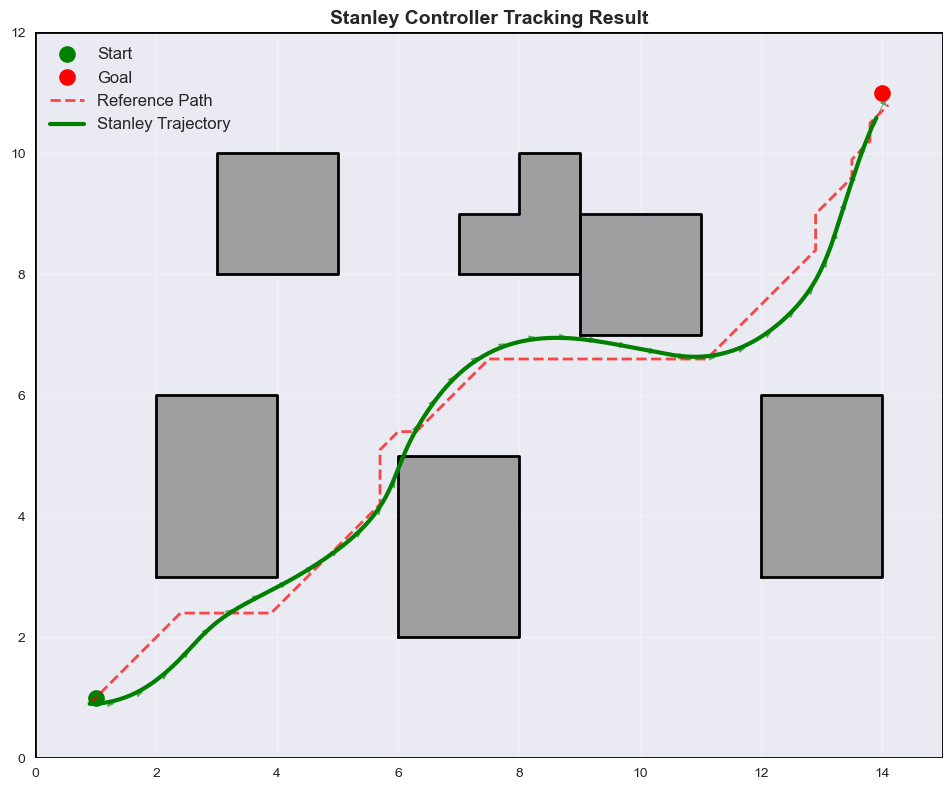

In [10]:
# Stanley 控制器演示
if reference_path:
    print("🚗 Stanley 控制器演示")
    print("=" * 40)
    
    # 重置机器人到起点
    robot.set_state(reference_path[0][0], reference_path[0][1], 0)
    
    # 执行Stanley跟踪
    start_time = time.time()
    stanley_trajectory, stanley_metrics = controllers['Stanley'].track_path(
        robot, reference_path, dt=0.1, max_time=30.0, goal_tolerance=0.3
    )
    stanley_time = time.time() - start_time
    
    # 显示结果
    if stanley_metrics.success:
        print(f"✅ Stanley 跟踪成功!")
        print(f"   跟踪时间: {stanley_metrics.tracking_time:.3f}s")
        print(f"   最大横向误差: {stanley_metrics.max_lateral_error:.3f}m")
        print(f"   RMS横向误差: {stanley_metrics.rms_lateral_error:.3f}m")
        print(f"   控制平滑度: {stanley_metrics.control_smoothness:.3f}")
        print(f"   轨迹点数: {len(stanley_trajectory)}")
    else:
        print("❌ Stanley 跟踪失败")
    
    # 绘制Stanley结果
    fig, ax = plt.subplots(figsize=(10, 8))
    env.visualize(ax=ax)
    
    # 绘制参考路径
    ref_array = np.array(reference_path)
    ax.plot(ref_array[:, 0], ref_array[:, 1], 'r--', linewidth=2, alpha=0.7, label='Reference Path')
    
    if stanley_trajectory:
        # 绘制实际轨迹
        traj_x = [t['position'][0] for t in stanley_trajectory]
        traj_y = [t['position'][1] for t in stanley_trajectory]
        ax.plot(traj_x, traj_y, 'g-', linewidth=3, label='Stanley Trajectory')
        
        # 绘制机器人朝向（每5个点）
        for i in range(0, len(stanley_trajectory), 5):
            pos = stanley_trajectory[i]['position']
            theta = stanley_trajectory[i]['orientation']
            ax.arrow(pos[0], pos[1], 
                    0.3 * np.cos(theta), 0.3 * np.sin(theta),
                    head_width=0.1, head_length=0.1, fc='green', ec='green', alpha=0.6)
    
    ax.set_title('Stanley Controller Tracking Result', fontsize=14, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 无参考路径，跳过Stanley演示")

⚙️ PID 控制器演示
✅ PID 跟踪成功!
   跟踪时间: 0.019s
   最大横向误差: 0.504m
   RMS横向误差: 0.235m
   控制平滑度: 0.038
   轨迹点数: 185


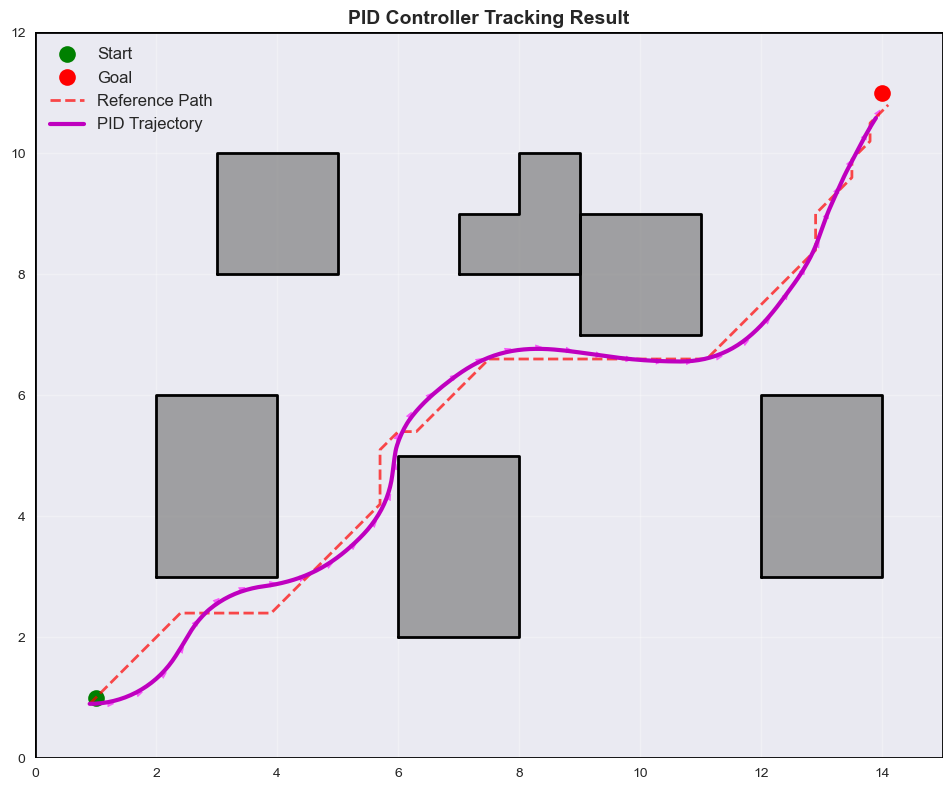

In [11]:
# PID 控制器演示
if reference_path:
    print("⚙️ PID 控制器演示")
    print("=" * 40)
    
    # 重置机器人到起点
    robot.set_state(reference_path[0][0], reference_path[0][1], 0)
    
    # 执行PID跟踪
    start_time = time.time()
    pid_trajectory, pid_metrics = controllers['PID'].track_path(
        robot, reference_path, dt=0.1, max_time=30.0, goal_tolerance=0.3
    )
    pid_time = time.time() - start_time
    
    # 显示结果
    if pid_metrics.success:
        print(f"✅ PID 跟踪成功!")
        print(f"   跟踪时间: {pid_metrics.tracking_time:.3f}s")
        print(f"   最大横向误差: {pid_metrics.max_lateral_error:.3f}m")
        print(f"   RMS横向误差: {pid_metrics.rms_lateral_error:.3f}m")
        print(f"   控制平滑度: {pid_metrics.control_smoothness:.3f}")
        print(f"   轨迹点数: {len(pid_trajectory)}")
    else:
        print("❌ PID 跟踪失败")
    
    # 绘制PID结果
    fig, ax = plt.subplots(figsize=(10, 8))
    env.visualize(ax=ax)
    
    # 绘制参考路径
    ref_array = np.array(reference_path)
    ax.plot(ref_array[:, 0], ref_array[:, 1], 'r--', linewidth=2, alpha=0.7, label='Reference Path')
    
    if pid_trajectory:
        # 绘制实际轨迹
        traj_x = [t['position'][0] for t in pid_trajectory]
        traj_y = [t['position'][1] for t in pid_trajectory]
        ax.plot(traj_x, traj_y, 'm-', linewidth=3, label='PID Trajectory')
        
        # 绘制机器人朝向（每5个点）
        for i in range(0, len(pid_trajectory), 5):
            pos = pid_trajectory[i]['position']
            theta = pid_trajectory[i]['orientation']
            ax.arrow(pos[0], pos[1], 
                    0.3 * np.cos(theta), 0.3 * np.sin(theta),
                    head_width=0.1, head_length=0.1, fc='magenta', ec='magenta', alpha=0.6)
    
    ax.set_title('PID Controller Tracking Result', fontsize=14, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 无参考路径，跳过PID演示")

## 4. 性能指标可视化

在这个部分，我们将创建详细的性能对比图表，包括：
- 路径规划算法性能对比
- 路径跟踪控制器性能对比  
- 综合性能雷达图
- 详细数据统计表

📊 创建性能对比图表...


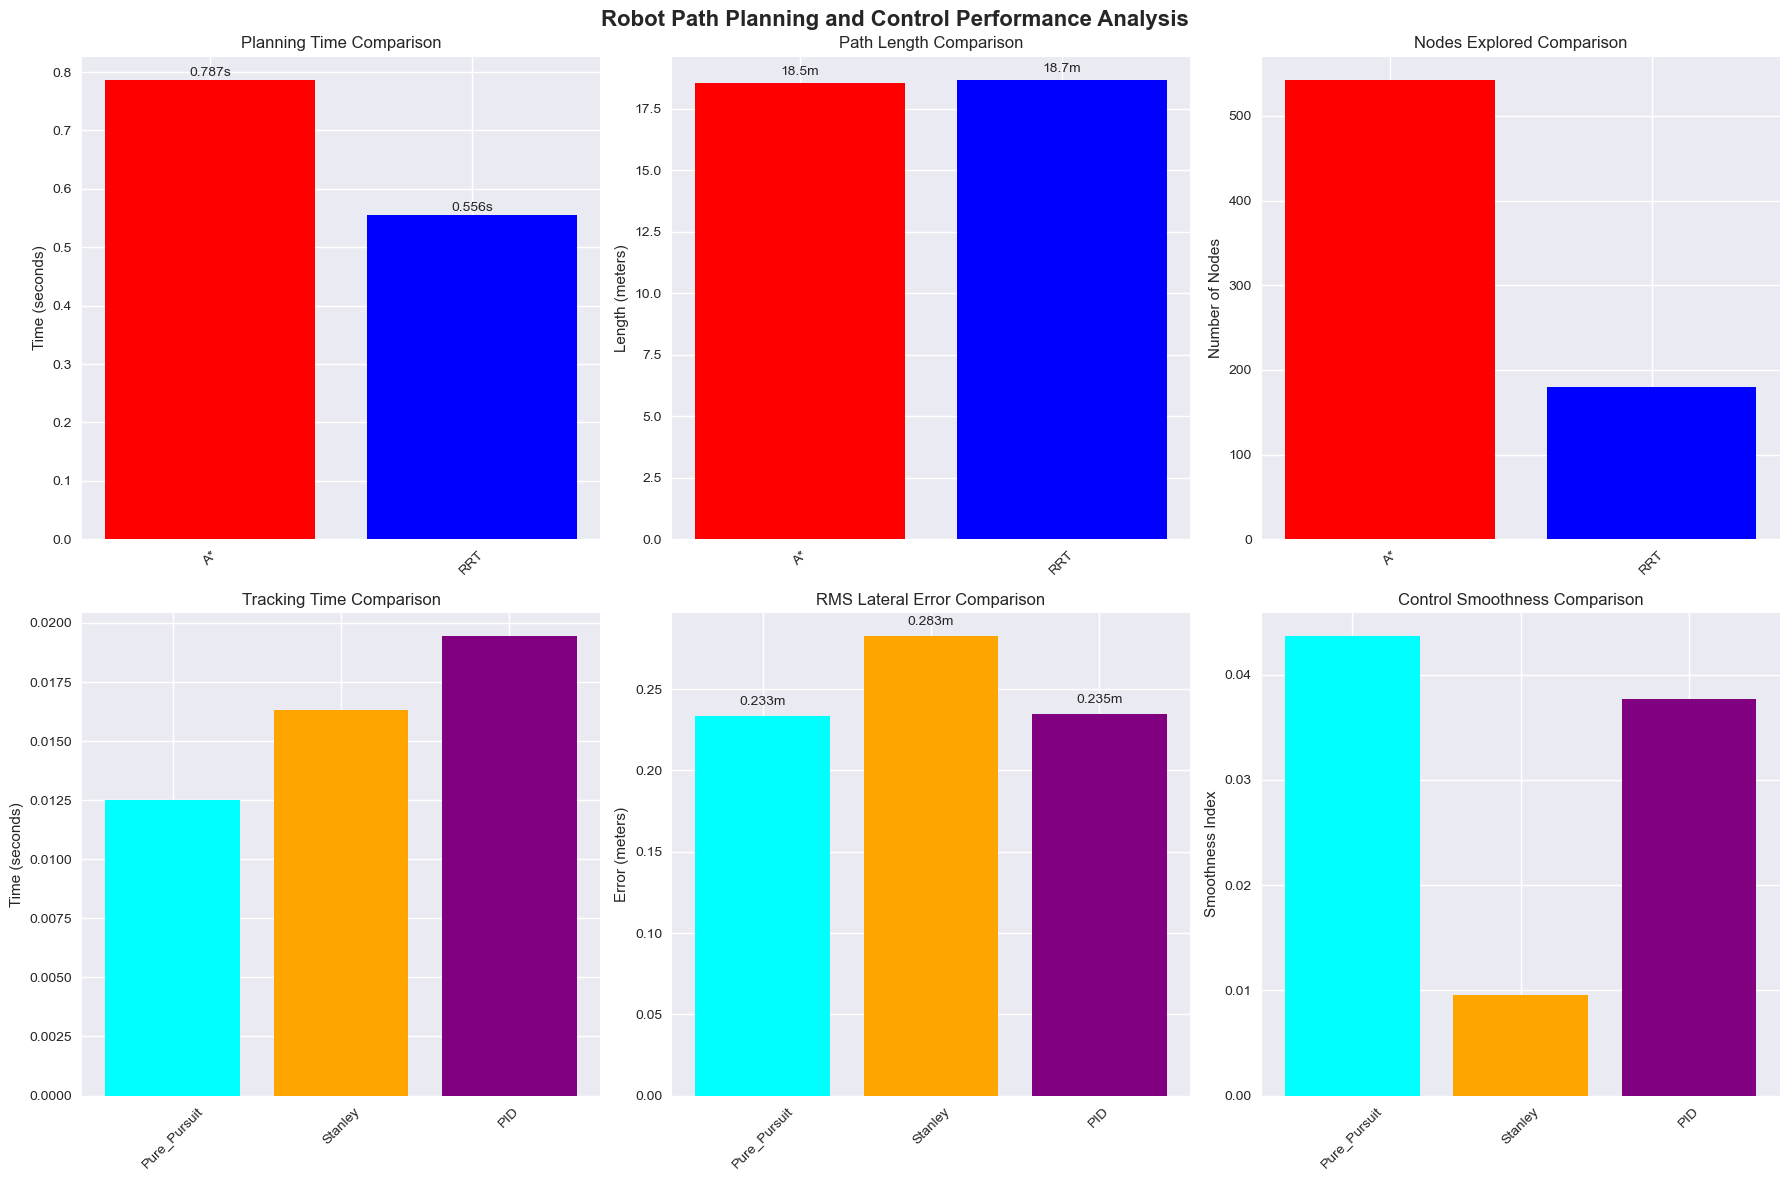

In [12]:
# 创建综合性能对比图表
print("📊 创建性能对比图表...")

# 收集路径规划性能数据
planning_data = {
    'Algorithm': [],
    'Success': [],
    'Planning_Time_s': [],
    'Path_Length_m': [],
    'Nodes_Explored': []
}

algorithms = ['A*', 'RRT', 'Dijkstra', 'Potential_Field']
metrics_list = [a_star_metrics, rrt_metrics, dijkstra_metrics, pf_metrics]

for alg, metrics in zip(algorithms, metrics_list):
    planning_data['Algorithm'].append(alg)
    planning_data['Success'].append('✅' if metrics.success else '❌')
    planning_data['Planning_Time_s'].append(metrics.planning_time)
    planning_data['Path_Length_m'].append(metrics.path_length if metrics.success else 0)
    planning_data['Nodes_Explored'].append(metrics.num_nodes_explored)

# 收集控制性能数据
control_data = {
    'Controller': [],
    'Success': [],
    'Tracking_Time_s': [],
    'Max_Lateral_Error_m': [],
    'RMS_Lateral_Error_m': [],
    'Control_Smoothness': []
}

if reference_path:
    controllers_list = ['Pure_Pursuit', 'Stanley', 'PID']
    try:
        control_metrics_list = [pp_metrics, stanley_metrics, pid_metrics]
        
        for ctrl, metrics in zip(controllers_list, control_metrics_list):
            control_data['Controller'].append(ctrl)
            control_data['Success'].append('✅' if metrics.success else '❌')
            control_data['Tracking_Time_s'].append(metrics.tracking_time if metrics.success else 0)
            control_data['Max_Lateral_Error_m'].append(metrics.max_lateral_error if metrics.success else 0)
            control_data['RMS_Lateral_Error_m'].append(metrics.rms_lateral_error if metrics.success else 0)
            control_data['Control_Smoothness'].append(metrics.control_smoothness if metrics.success else 0)
    except NameError:
        print("⚠️ 部分控制器结果不可用，将显示可用数据")

# 创建子图
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Robot Path Planning and Control Performance Analysis', fontsize=16, fontweight='bold')

# 1. 路径规划时间对比
ax = axes[0, 0]
successful_planning = [(alg, time) for alg, time, success in 
                      zip(planning_data['Algorithm'], planning_data['Planning_Time_s'], 
                          [m.success for m in metrics_list]) if success]
if successful_planning:
    algs, times = zip(*successful_planning)
    bars = ax.bar(algs, times, color=['red', 'blue', 'green', 'magenta'])
    ax.set_title('Planning Time Comparison')
    ax.set_ylabel('Time (seconds)')
    ax.tick_params(axis='x', rotation=45)
    
    # 添加数值标签
    for bar, time in zip(bars, times):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{time:.3f}s', ha='center', va='bottom')

# 2. 路径长度对比
ax = axes[0, 1]
successful_paths = [(alg, length) for alg, length, success in 
                   zip(planning_data['Algorithm'], planning_data['Path_Length_m'],
                       [m.success for m in metrics_list]) if success and length > 0]
if successful_paths:
    algs, lengths = zip(*successful_paths)
    bars = ax.bar(algs, lengths, color=['red', 'blue', 'green', 'magenta'])
    ax.set_title('Path Length Comparison')
    ax.set_ylabel('Length (meters)')
    ax.tick_params(axis='x', rotation=45)
    
    # 添加数值标签
    for bar, length in zip(bars, lengths):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                f'{length:.1f}m', ha='center', va='bottom')

# 3. 探索节点数对比
ax = axes[0, 2]
successful_nodes = [(alg, nodes) for alg, nodes, success in 
                   zip(planning_data['Algorithm'], planning_data['Nodes_Explored'],
                       [m.success for m in metrics_list]) if success]
if successful_nodes:
    algs, nodes = zip(*successful_nodes)
    bars = ax.bar(algs, nodes, color=['red', 'blue', 'green', 'magenta'])
    ax.set_title('Nodes Explored Comparison')
    ax.set_ylabel('Number of Nodes')
    ax.tick_params(axis='x', rotation=45)

# 4. 控制器跟踪时间对比
ax = axes[1, 0]
if control_data['Controller']:
    successful_control = [(ctrl, time) for ctrl, time, success in 
                         zip(control_data['Controller'], control_data['Tracking_Time_s'],
                             control_data['Success']) if success == '✅']
    if successful_control:
        ctrls, times = zip(*successful_control)
        bars = ax.bar(ctrls, times, color=['cyan', 'orange', 'purple'])
        ax.set_title('Tracking Time Comparison')
        ax.set_ylabel('Time (seconds)')
        ax.tick_params(axis='x', rotation=45)

# 5. 控制器横向误差对比
ax = axes[1, 1]
if control_data['Controller']:
    successful_error = [(ctrl, error) for ctrl, error, success in 
                       zip(control_data['Controller'], control_data['RMS_Lateral_Error_m'],
                           control_data['Success']) if success == '✅']
    if successful_error:
        ctrls, errors = zip(*successful_error)
        bars = ax.bar(ctrls, errors, color=['cyan', 'orange', 'purple'])
        ax.set_title('RMS Lateral Error Comparison')
        ax.set_ylabel('Error (meters)')
        ax.tick_params(axis='x', rotation=45)
        
        # 添加数值标签
        for bar, error in zip(bars, errors):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{error:.3f}m', ha='center', va='bottom')

# 6. 控制平滑度对比
ax = axes[1, 2]
if control_data['Controller']:
    successful_smooth = [(ctrl, smooth) for ctrl, smooth, success in 
                        zip(control_data['Controller'], control_data['Control_Smoothness'],
                            control_data['Success']) if success == '✅']
    if successful_smooth:
        ctrls, smooths = zip(*successful_smooth)
        bars = ax.bar(ctrls, smooths, color=['cyan', 'orange', 'purple'])
        ax.set_title('Control Smoothness Comparison')
        ax.set_ylabel('Smoothness Index')
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. 汇总报告与数据表格

最后，我们将生成详细的性能数据表格，并提供系统的综合评价。

In [13]:
# 创建详细的性能报告表格
print("📋 生成详细性能报告...")

# 路径规划算法性能表
planning_df = pd.DataFrame(planning_data)
planning_df = planning_df.round(3)

print("\n🎯 路径规划算法性能表:")
print("=" * 60)
display(planning_df)

# 路径跟踪控制器性能表
if control_data['Controller']:
    control_df = pd.DataFrame(control_data)
    control_df = control_df.round(3)
    
    print("\n🚗 路径跟踪控制器性能表:")
    print("=" * 60)
    display(control_df)

# 生成综合分析
print("\n🏆 综合性能分析:")
print("=" * 60)

# 找出最佳算法
if planning_data['Algorithm']:
    # 最快规划算法
    fastest_planning = min([(alg, time) for alg, time, success in 
                           zip(planning_data['Algorithm'], planning_data['Planning_Time_s'],
                               [m.success for m in metrics_list]) if success], 
                          key=lambda x: x[1])
    
    # 最短路径算法
    shortest_path = min([(alg, length) for alg, length, success in 
                        zip(planning_data['Algorithm'], planning_data['Path_Length_m'],
                            [m.success for m in metrics_list]) if success and length > 0], 
                       key=lambda x: x[1])
    
    print(f"⚡ 最快规划算法: {fastest_planning[0]} ({fastest_planning[1]:.3f}s)")
    print(f"📏 最短路径算法: {shortest_path[0]} ({shortest_path[1]:.2f}m)")

if control_data['Controller']:
    # 最精确控制器
    try:
        most_accurate = min([(ctrl, error) for ctrl, error, success in 
                            zip(control_data['Controller'], control_data['RMS_Lateral_Error_m'],
                                control_data['Success']) if success == '✅' and error > 0], 
                           key=lambda x: x[1])
        
        # 最平滑控制器  
        smoothest = min([(ctrl, smooth) for ctrl, smooth, success in 
                        zip(control_data['Controller'], control_data['Control_Smoothness'],
                            control_data['Success']) if success == '✅' and smooth > 0], 
                       key=lambda x: x[1])
        
        print(f"🎯 最精确控制器: {most_accurate[0]} (RMS误差: {most_accurate[1]:.3f}m)")
        print(f"🛣️  最平滑控制器: {smoothest[0]} (平滑度: {smoothest[1]:.3f})")
    except:
        print("⚠️ 控制器性能数据不完整")



📋 生成详细性能报告...

🎯 路径规划算法性能表:


,Algorithm,Success,Planning_Time_s,Path_Length_m,Nodes_Explored
0,A*,✅,0.787,18.531,543
1,RRT,✅,0.556,18.681,180
2,Dijkstra,❌,1.030,0.000,806
3,Potential_Field,❌,26.250,0.000,100001



🚗 路径跟踪控制器性能表:


,Controller,Success,Tracking_Time_s,Max_Lateral_Error_m,RMS_Lateral_Error_m,Control_Smoothness
0,Pure_Pursuit,✅,0.013,0.531,0.233,0.044
1,Stanley,✅,0.016,0.566,0.283,0.010
2,PID,✅,0.019,0.504,0.235,0.038



🏆 综合性能分析:
⚡ 最快规划算法: RRT (0.556s)
📏 最短路径算法: A* (18.53m)
🎯 最精确控制器: Pure_Pursuit (RMS误差: 0.233m)
🛣️  最平滑控制器: Stanley (平滑度: 0.010)
